# Approximation of hydrodynamic force derivatives

## Importing necessary modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, StrMethodFormatter

import scipy.optimize as sco
import scipy.stats as scs
import scipy.interpolate as sci

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, LassoLars, SGDRegressor, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

## Change font parameters for plotting

In [2]:
plt.rcParams["font.size"] = '14'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

## Defining function for contour plot of measuered scatter data

In [3]:
def scat2cfplot(data,cMap,Lvl):

    x,y,zl,zm,zr = data
    lLv,mLv,rLv  = Lvl
    wf = 15
    hf = 3
    fig,(axl,axm,axr) = plt.subplots(1,3,figsize=(wf,hf))

    axl.set_title('$X_{Hdl}$')
    scf = axl.tricontourf(x,y,zl,cmap=cMap,levels=lLv)
    axl.set_xlabel(r'$\beta$')
    axl.set_ylabel(r'$r_{dl}$')
    axl.xaxis.set_major_formatter(EngFormatter(unit=u"°"))
    axl.set_aspect(1.0/axl.get_data_ratio(), adjustable='box')
    fig.colorbar(scf,ax=axl,format='%4.1f',shrink=.75,ticks=lLv[::2])

    axm.set_title('$Y_{Hdl}$')
    scf = axm.tricontourf(x,y,zm,cmap=cMap,levels=mLv)
    axm.set_xlabel(r'$\beta$')
    axm.set_aspect(1.0/axm.get_data_ratio(), adjustable='box')
    axm.set_ylabel(r'$r_{dl}$')
    axm.xaxis.set_major_formatter(EngFormatter(unit=u"°"))
    fig.colorbar(scf,ax=axm,format='%4.1f',shrink=.75,ticks=mLv[::2])

    axr.set_title('$N_{Hdl}$')
    scf = axr.tricontourf(x,y,zr,cmap=cMap,levels=rLv)
    axr.set_xlabel(r'$\beta$')
    axr.set_ylabel(r'$r_{dl}$')
    axr.xaxis.set_major_formatter(EngFormatter(unit=u"°"))
    axr.set_aspect(1.0/axr.get_data_ratio(), adjustable='box')
    fig.colorbar(scf,ax=axr,format='%4.1f',shrink=.75,ticks=rLv[::2])

    return(fig,axl,axm,axr)


## Building regression models with random search of model parameters

In [4]:
def predpoly(X,Y,Xo,est,par_gri,REP=False):
    clf = RandomizedSearchCV(est,par_gri,random_state=12321,n_iter=15)
    clf.fit(X,Y)
    bp = clf.best_params_
    est.set_params(**bp)
    est.fit(X,Y)
    pred = est.predict(X)
    sco,coef,mse_ = (est.score(X,Y),est.coef_,mse(pred,Y))
    prod = est.predict(Xo)

    res = pred-Y
    bia = np.sum(res)/len(pred)
    var = np.var(pred)
    ioa = 1-np.sum(res**2)/np.sum((np.abs(pred-np.mean(Y))+np.abs(Y-np.mean(Y)))**2)

    if REP:
        print('\n Bias:%10.1e'%bia)
        print('  Var:%10.1e'%var)
        print('  IOA:%10.2f'%ioa)
        print('   R2:%10.3f'%sco)
        print('  MSE:%10.1e'%mse_)
        for k in bp:
            try:
                a = float(bp[k])
                print('%16s:%10.2e'%(k,bp[k]))
            except:
                print('%16s:%10s'%(k,bp[k]))
    return(pd.Series(pred.ravel()),pd.Series(prod.ravel()),coef,sco,mse_)

## Reading data and setting regression model features

In [5]:
iDir,pDir = 'input/', 'plots/'

SEED = 12321

cl = '#fa00a0'
cs = '#00afa0'

xLvl = np.linspace(5,20,16)
xLvl = [np.linspace(-0.3,0.3,13),np.linspace(-.6,.6,13),np.linspace(-.3,.3,13)]

df = pd.read_csv(iDir + 'data.csv',sep=';')
data = [df.vm,df.rdl,df.XH,df.YH,df.NH]

X   = np.array([data[0],data[1]]).T
Yx   = data[2].values.reshape(-1,1)
Yy   = data[3].values.reshape(-1,1)
Yn   = data[4].values.reshape(-1,1)


Yx   = data[2].values.ravel()
Yy   = data[3].values.ravel()
Yn   = data[4].values.ravel()

nb,nr = (101,101)

xl,yl = (np.linspace(-.35,.35,nb),np.linspace(-.80,.80,nr))
xg,yg = np.meshgrid(xl,yl)
bg = -np.degrees(np.arcsin(xg))

Xo = np.concatenate((xg.reshape(-1,1),yg.reshape(-1,1)),axis=1).T
v,r = (X.T[0],X.T[1])
Xx = np.array([v**2,v*r,r**2,v**3]).T
Xy = np.array([v,r,v**3,v**2*r,v*r**2,r**3]).T

v,r = (Xo[0],Xo[1])
Xxo = np.array([v**2,v*r,r**2,v**3]).T
Xyo = np.array([v,r,v**3,v**2*r,v*r**2,r**3]).T

## Preparation of vectors with selected models

In [6]:
m_name = ['Ridge','LassoLars','ElasticNet','SGDRegressor']

model  = {'Ridge'        : Ridge(),
          'LassoLars'    : LassoLars(),
          'ElasticNet'   : ElasticNet(),
          'SGDRegressor' : SGDRegressor()}

cMap   = {'Ridge'         : 'PuRd',
          'LassoLars'     : 'BuPu',
          'ElasticNet'    : 'BuGn',
          'SGDRegressor'  : 'YlGn'}

par_gri = {'Ridge'       : {'alpha': np.linspace(0.0,1,3000)},
           'LassoLars'   : {'alpha': np.linspace(0,1e-3,200)},
           'ElasticNet'  : {'tol':[1e-6],'alpha': np.linspace(0,1e-3,200), 'l1_ratio':np.linspace(0.5,1.0,25)},
           'SGDRegressor': {'tol':[1e-4,1e-6],'power_t': np.linspace(-.5,.5,1000)}}

## Looping models with prepared data, prediction, calcuation of metrics, plotting



 Ridge


,X,Y,N
R2,0.991850,0.992102,0.988863
MSE,0.000029,0.000342,0.000034




 LassoLars


,X,Y,N
R2,0.991734,0.992396,0.988549
MSE,0.000029,0.000329,0.000035




 ElasticNet


,X,Y,N
R2,0.992104,0.992517,0.990408
MSE,0.000028,0.000324,0.000029




 SGDRegressor


,X,Y,N
R2,0.990101,0.979744,0.983033
MSE,0.000035,0.000877,0.000052


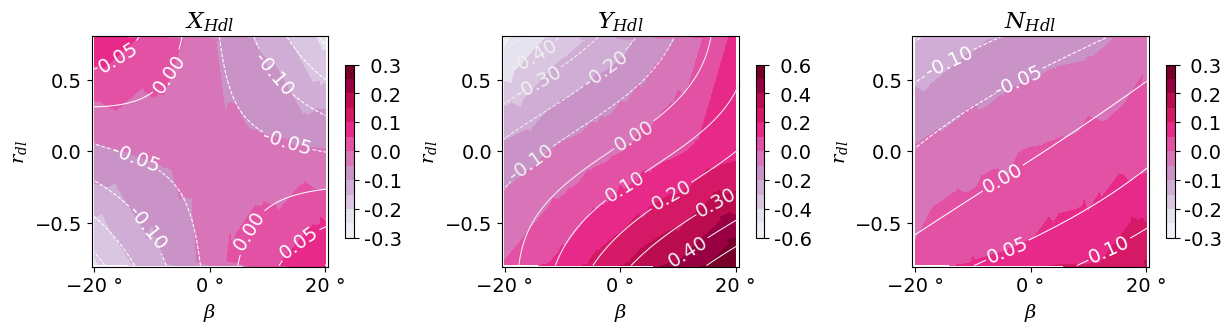

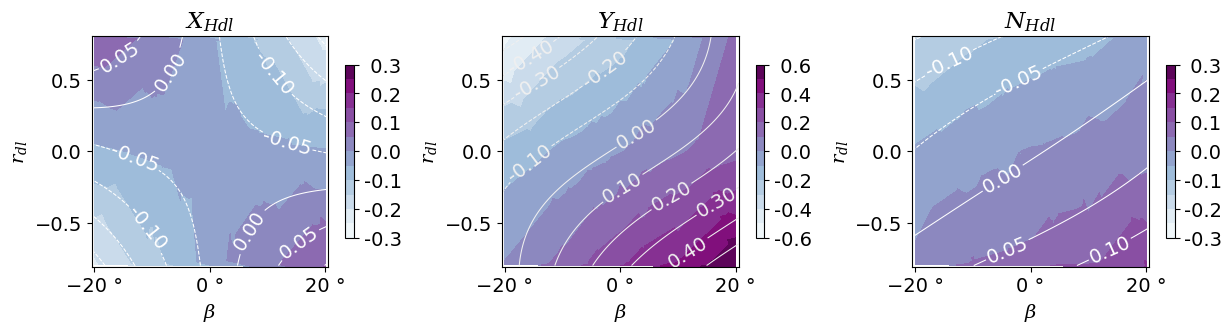

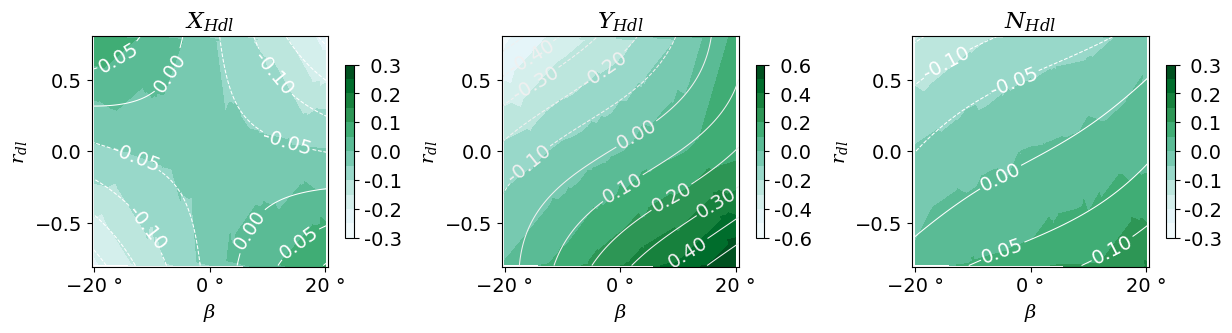

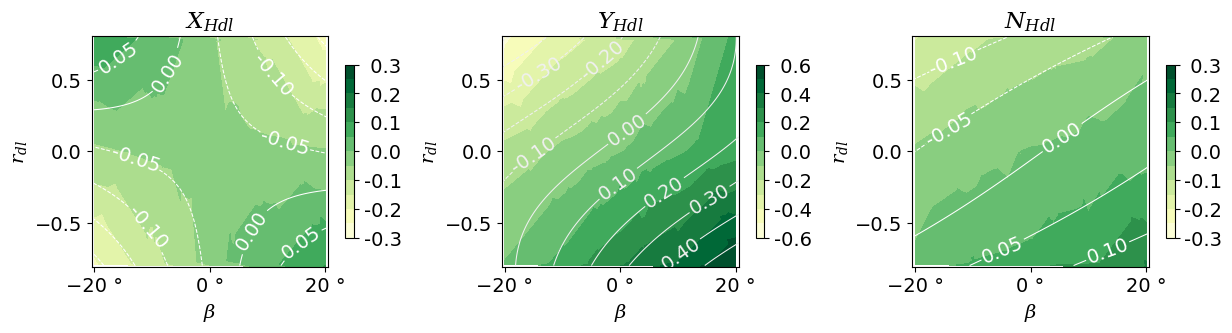

In [7]:
vcfx,vcfy,vcfn = [],[],[]

for mn in m_name:
    print('\n\n',mn)
    zPrex,zProx,cfx,r2x,msex = predpoly(Xx,Yx,Xxo,model[mn],par_gri[mn])
    zPrey,zProy,cfy,r2y,msey = predpoly(Xy,Yy,Xyo,model[mn],par_gri[mn])
    zPren,zPron,cfn,r2n,msen = predpoly(Xy,Yn,Xyo,model[mn],par_gri[mn])

    vcfx = np.append(vcfx,cfx)
    vcfy = np.append(vcfy,cfy)
    vcfn = np.append(vcfn,cfn)

    key = ['X','Y','N']
    dfr = pd.DataFrame(columns=key,index=['R2','MSE'])
    dfr.X = [r2x,msex]
    dfr.Y = [r2y,msey]
    dfr.N = [r2n,msen]

    zgx = zProx.to_numpy().reshape(nb,-1)
    zgy = zProy.to_numpy().reshape(nb,-1)
    zgn = zPron.to_numpy().reshape(nb,-1)
    #fig,axx,axy,axn = scat2cfplot([pd.Series(Xo[0]),pd.Series(Xo[1]),zProx,zProy,zPron],cMap,xLvl)
    data[0] = df.beta

    fig,axx,axy,axn = scat2cfplot(data,cMap[mn],xLvl)
    cx = axx.contour(bg,yg,zgx,colors='#ffffff',levels=xLvl[0],linewidths=.75)
    cy = axy.contour(bg,yg,zgy,colors='#f0f0f0',levels=xLvl[1],linewidths=.75)
    cn = axn.contour(bg,yg,zgn,colors='#ffffff',levels=xLvl[2],linewidths=.75)

    axx.clabel(cx,cx.levels,inline=True,fmt='%3.2f')
    axy.clabel(cy,cy.levels,inline=True,fmt='%3.2f')
    axn.clabel(cn,cn.levels,inline=True,fmt='%3.2f')

    display(dfr)
    
    fig.savefig('hf-'+mn+'.png',dpi=300,bbox_inches='tight')

## Display of coefficients comparison

In [8]:
key = ['Xvv','Xvr','Xrr','Xvvv']
vec = vcfx.reshape(len(m_name),-1)
dfx = pd.DataFrame(dict(zip(key,vec.T)),index=m_name)

key = ['Yv','Yr','Yvvv','Yvvr','Yvrr','Yrrr']
vec = vcfy.reshape(len(m_name),-1)
dfy = pd.DataFrame(dict(zip(key,vec.T)),index=m_name)


key = [x.replace('Y','N') for x in key]
vec = vcfn.reshape(len(m_name),-1)
dfn = pd.DataFrame(dict(zip(key,vec.T)),index=m_name)

display(dfx)
display(dfy)
display(dfn)

,Xvv,Xvr,Xrr,Xvvv
Ridge,-0.189451,0.566973,-0.005430,-0.107522
LassoLars,-0.188719,0.570905,-0.005169,-0.085659
ElasticNet,-0.198136,0.572392,-0.005053,-0.127653
SGDRegressor,-0.166581,0.566653,-0.007540,-0.039207


,Yv,Yr,Yvvv,Yvvr,Yvrr,Yrrr
Ridge,-0.497576,-0.320396,-0.358890,0.015567,-0.573969,-0.001173
LassoLars,-0.473861,-0.320297,-0.595808,0.000000,-0.584206,0.000000
ElasticNet,-0.453790,-0.320916,-0.816299,0.012514,-0.584695,0.000000
SGDRegressor,-0.540877,-0.307194,-0.104826,0.000956,-0.526852,0.008858


,Nv,Nr,Nvvv,Nvvr,Nvrr,Nrrr
Ridge,-0.107822,-0.071669,-0.172155,-0.103026,-0.081357,-0.044526
LassoLars,-0.109721,-0.072662,-0.160920,-0.087587,-0.077269,-0.043718
ElasticNet,-0.089280,-0.071340,-0.385390,-0.115002,-0.077793,-0.044113
SGDRegressor,-0.130454,-0.078077,-0.015093,-0.009851,-0.045832,-0.042204
